In [2]:
# Zachary Katz
# zachary_katz@mines.edu
# 27 May 2025

"""
Example harmonic analysis 
"""

# Extensions
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from utide import solve
import pandas as pd

import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time
import Tides.Tides as Tides
import datetime
import seaborn as sns
from pyproj import CRS, Transformer


def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load ROSS GNSS For Comparison
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import os

data_dir = "/mnt/c/users/zacharykatz/desktop/research/GeorgeVI/_Data/ROSS/"
dfs = []
stas = []
for mat_file in os.listdir(data_dir):
    if mat_file.endswith(".mat"):
        # Load the .mat file
        data = loadmat(os.path.join(data_dir, mat_file))
        print(mat_file[:7])
        sta = mat_file[:7]
        df = pd.DataFrame(
            data["DATA"][:, [0, 1, 2, 3]], columns=["date", "x", "y", "z"]
        )
        df["sta"] = sta
        dfs.append(df)
        stas.append(sta)
        # ross_x.append(data['DATA'][0][0])
        # ross_y.append(data['DATA'][0][1])

for df in dfs:
    origin = pd.Timestamp("2015-01-01")
    df["date"] = origin + pd.to_timedelta(df["date"], unit="D")

TS_DR01
TS_DR02
TS_DR03
TS_DR04
TS_DR05
TS_DR10
TS_DR14
TS_DR15
TS_DR16
TS_RS03
TS_RS16
TS_RS18


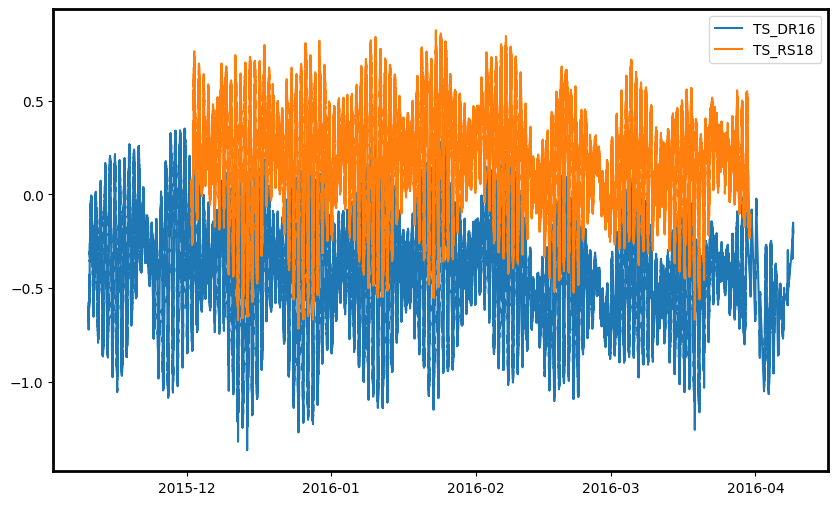

In [3]:
# Cull df to april 1 2015
df = dfs[11]
rs18 = df[df["date"] <= "2016-04-10"]
df = dfs[8]
dr16 = df[df["date"] <= "2016-04-10"]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dr16["date"], dr16["z"], label=dr16["sta"][0])
ax.plot(rs18["date"], rs18["z"], label=rs18["sta"][0])
ax.legend()

In [4]:
# Satellite repeat times [hr]
HR_IN_DAY = 24
SEC_IN_HR = 3600
T_icesat2 = 90.8193 * HR_IN_DAY  # 90.8193 days in hrs (From ATL03 POD ATBD)
T_swot = 20.86455 * HR_IN_DAY  # 21 days in hrs
T_cryosat_subcycle = 28.941 * HR_IN_DAY  # 28 days in hrs
T_jason = 9.9156 * HR_IN_DAY  # 9 days in hrs

# Tidal constituents [hr]
M2 = 12.4206012
S2 = 12
N2 = 12.65834751
K2 = 11.96723606

K1 = 23.9344721
O1 = 25.81933871
P1 = 24.06588766
Q1 = 26.868350

constituents = {
    "M2": M2,
    "S2": S2,
    "N2": N2,
    "K2": K2,
    "K1": K1,
    "O1": O1,
    "P1": P1,
    "Q1": Q1,
}

In [5]:
def tide_model(t, periods, parameters):
    """
    Generate the tide from synthetic data.

    Parameters
    ----------
    t : List
        List of sampling times in hours
    periods : dict
        Dictionary of tidal constituent periods in hours
    parameters : list
        List in form [A1, A2, ... , phi_1, phi_2, ...]
        where A is the amplitude in m and phi is the phase shift in radians

    Returns
    -------
    modeled : list
        Tides at time t as estimated by the model
    """
    assert len(parameters) == 2 * len(
        periods
    ), "Parameters must be twice the number of periods"

    model = np.zeros_like(t, dtype=float)
    n = len(periods)
    for i in range(n):
        A = parameters[i]
        phi = parameters[i + n]
        model += A * np.cos(2 * np.pi * t / periods[i] - phi)
    return model


def residuals(parameters, t, data, periods):
    """
    Residual function for scipy's least_squares
    Scipy does the squaring for us.
    """
    return tide_model(t, periods, parameters) - data

True: 1.000, Fitted: 1.029
True: 2.000, Fitted: 1.995
True: 0.300, Fitted: 0.273
True: 2.000, Fitted: 1.994
True: 1.000, Fitted: 0.991
True: 2.000, Fitted: 1.989
True: 0.000, Fitted: -0.023
True: 1.000, Fitted: 0.994
True: 0.000, Fitted: 0.031
True: 0.000, Fitted: -0.008
True: 0.000, Fitted: 0.015
True: 0.000, Fitted: -0.000
True: 1.571, Fitted: -4.698
True: 0.393, Fitted: 0.393
True: 0.000, Fitted: 9.939
True: 0.785, Fitted: 0.816


Text(0, 0.5, 'Tide [m]')

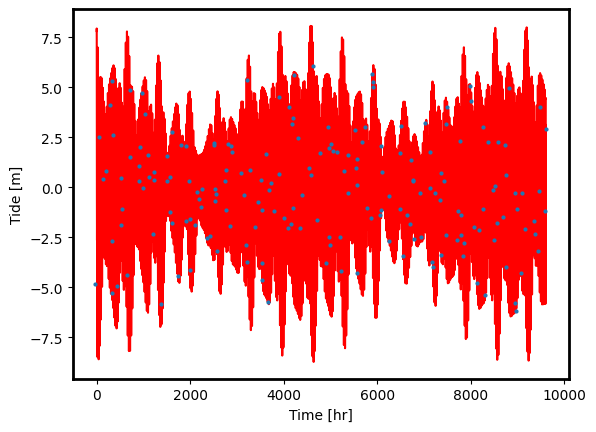

In [6]:
step = T_swot // 10  # hrs
t = np.arange(0, 400 * 24, step)
t = t + np.random.normal(0, 100, len(t))  # Nonuniform sampling
periods = [constituents[c] for c in constituents]
true_values = [1, 2, 0.3, 2, 1, 2, 0, 1, 0, 0, 0, 0, np.pi / 2, np.pi / 8, 0, np.pi / 4]

synthetic_data = tide_model(t, periods, true_values) + np.random.normal(0, 0.2, len(t))

initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, synthetic_data, periods))

# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    print(f"True: {true:.3f}, Fitted: {fitted:.3f}")

fig, ax = plt.subplots()
ax.scatter(t, synthetic_data, s=4)
fit_times = np.arange(0, 400 * 24, 0.1)
fit_tide = tide_model(fit_times, periods, fit.x)
ax.plot(fit_times, fit_tide, color="red", zorder=0)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Tide [m]")

In [7]:
t_as_time = pd.date_range(start="2020-01-02T08:50:00", periods=len(t), freq=f"{step}h")
# Utide analysis
soln = solve(t_as_time, synthetic_data, lat=-84.2986, method="ols", conf_int="linear")
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: BET1, Amplitude: 59381878199.14297, A_ci: nan Phase: 4.953452997920134, g_ci: nan
Constitutent: 2MN6, Amplitude: 27473789390.063934, A_ci: nan Phase: 1.0552920646682533, g_ci: nan
Constitutent: SA, Amplitude: 3928867490.8383927, A_ci: 5.182010490782109e-05 Phase: 1.8277297131715322, g_ci: 3.285639026553568e-13
Constitutent: CHI1, Amplitude: 2523400053.9914594, A_ci: nan Phase: 5.679096350471896, g_ci: nan
Constitutent: L2, Amplitude: 2218932983.113098, A_ci: nan Phase: 1.378135915628196, g_ci: nan
Constitutent: MKS2, Amplitude: 2175493664.961712, A_ci: nan Phase: 0.2944278462633838, g_ci: nan
Constitutent: M2, Amplitude: 1580789015.3721905, A_ci: nan Phase: 2.9561521618690807, g_ci: nan
Constitutent: MO3, Amplitude: 1518195945.9615564, A_ci: nan Phase: 2.0439143312345074, g_ci: nan
Constitutent: PHI1, Amplitude: 1513943189.3355317, A_ci: nan Phase: 2.0123778373698826, g_ci: nan
Constitutent: M3, Amplitude: 1171344004.6707861, A_ci

In [8]:
# Try with IceSat-2 crossover at gz05
# User-defined path
data_path = "../data/ATL11/"

# Download ATL11 if necessary
granule_names = [
    "ATL11_134011_0326_006_12.h5",
    "ATL11_102111_0326_006_12.h5",
    "ATL11_112111_0326_006_12.h5",
    "ATL11_107511_0326_006_12.h5",
]
for granule_name in granule_names:
    results = earthaccess.search_data(
        short_name="ATL11",
        granule_name=granule_name,
    )
    print(results)
    earthaccess.download(results, data_path, provider="POCLOUD")
files = list(Path(data_path).glob("*.h5"))

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -153.59526, 'Latitude': -78.98162}, {'Longitude': -153.87878, 'Latitude': -78.9677}, {'Longitude': -153.99141, 'Latitude': -78.98917}, {'Longitude': -155.48991, 'Latitude': -80.24384}, {'Longitude': -160.10742, 'Latitude': -82.8004}, {'Longitude': -164.22914, 'Latitude': -84.16105}, {'Longitude': 178.20076, 'Latitude': -86.664}, {'Longitude': 157.00415, 'Latitude': -87.60905}, {'Longitude': 88.84637, 'Latitude': -87.43669}, {'Longitude': 56.05837, 'Latitude': -84.17317}, {'Longitude': 49.46781, 'Latitude': -81.64929}, {'Longitude': 47.27274, 'Latitude': -80.24236}, {'Longitude': 45.77733, 'Latitude': -78.98982}, {'Longitude': 45.71627, 'Latitude': -78.97243}, {'Longitude': 45.60891, 'Latitude': -78.96835}, {'Longitude': 45.53695, 'Latitude': -78.97633}, {'Longitude': 45.24915, 

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 514.07it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4088.02it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8981.38it/s]


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 179.85048, 'Latitude': -79.62305}, {'Longitude': 175.77768, 'Latitude': -82.2103}, {'Longitude': 167.96292, 'Latitude': -84.72366}, {'Longitude': 147.58093, 'Latitude': -86.9958}, {'Longitude': 89.03956, 'Latitude': -87.90811}, {'Longitude': 44.41772, 'Latitude': -86.3511}, {'Longitude': 35.16444, 'Latitude': -85.15627}, {'Longitude': 26.33484, 'Latitude': -82.74471}, {'Longitude': 20.3503, 'Latitude': -78.98981}, {'Longitude': 20.28922, 'Latitude': -78.97242}, {'Longitude': 20.18185, 'Latitude': -78.96835}, {'Longitude': 20.10973, 'Latitude': -78.97636}, {'Longitude': 19.82096, 'Latitude': -78.98408}, {'Longitude': 19.75899, 'Latitude': -79.01208}, {'Longitude': 23.06214, 'Latitude': -81.55325}, {'Longitude': 28.57619, 'Latitude': -83.92244}, {'Longitude': 41.83464, 'Latitude'

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 593.59it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6472.69it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6159.04it/s]


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -21.12473, 'Latitude': -78.97534}, {'Longitude': -21.25291, 'Latitude': -78.96729}, {'Longitude': -21.36554, 'Latitude': -78.98875}, {'Longitude': -23.0168, 'Latitude': -80.35496}, {'Longitude': -27.98981, 'Latitude': -83.00056}, {'Longitude': -38.32304, 'Latitude': -85.50742}, {'Longitude': -49.33157, 'Latitude': -86.67351}, {'Longitude': -104.84451, 'Latitude': -87.94569}, {'Longitude': -165.13304, 'Latitude': -85.42898}, {'Longitude': -175.45456, 'Latitude': -82.80251}, {'Longitude': 178.4198, 'Latitude': -78.98974}, {'Longitude': 178.35872, 'Latitude': -78.97235}, {'Longitude': 178.25136, 'Latitude': -78.96828}, {'Longitude': 178.17889, 'Latitude': -78.97635}, {'Longitude': 177.88853, 'Latitude': -78.98408}, {'Longitude': 177.82658, 'Latitude': -79.01209}, {'Longitude': -17

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1152.60it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5084.00it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 5419.00it/s]


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -14.63508, 'Latitude': -78.97552}, {'Longitude': -14.76337, 'Latitude': -78.96745}, {'Longitude': -14.876, 'Latitude': -78.98891}, {'Longitude': -18.39584, 'Latitude': -81.55198}, {'Longitude': -21.07863, 'Latitude': -82.83373}, {'Longitude': -31.68911, 'Latitude': -85.48572}, {'Longitude': -41.62631, 'Latitude': -86.58096}, {'Longitude': -95.77303, 'Latitude': -87.94914}, {'Longitude': -146.58118, 'Latitude': -86.71297}, {'Longitude': -158.03256, 'Latitude': -85.52278}, {'Longitude': -168.58549, 'Latitude': -82.95491}, {'Longitude': -173.49702, 'Latitude': -80.314}, {'Longitude': -175.09157, 'Latitude': -78.98952}, {'Longitude': -175.15265, 'Latitude': -78.97213}, {'Longitude': -175.26001, 'Latitude': -78.96806}, {'Longitude': -175.33273, 'Latitude': -78.97618}, {'Longitude': 

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 701.74it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5785.25it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6875.91it/s]


In [9]:
# Print available groups from file 1
!h5dump -n {files[0]}

HDF5 "../data/ATL11/ATL11_107511_0326_006_12.h5" {
FILE_CONTENTS {
 group      /
 group      /METADATA
 group      /METADATA/AcquisitionInformation
 group      /METADATA/AcquisitionInformation/lidar
 group      /METADATA/AcquisitionInformation/lidarDocument
 group      /METADATA/AcquisitionInformation/platform
 group      /METADATA/AcquisitionInformation/platformDocument
 group      /METADATA/DataQuality
 group      /METADATA/DataQuality/CompletenessOmission
 group      /METADATA/DataQuality/DomainConsistency
 group      /METADATA/DatasetIdentification
 group      /METADATA/Extent
 group      /METADATA/Lineage
 group      /METADATA/Lineage/ANC36-11
 group      /METADATA/Lineage/ANC38-11
 group      /METADATA/Lineage/ATL06
 group      /METADATA/Lineage/Control
 group      /METADATA/ProcessStep
 group      /METADATA/ProcessStep/Browse
 group      /METADATA/ProcessStep/Metadata
 group      /METADATA/ProcessStep/PGE
 group      /METADATA/ProcessStep/QA
 group      /METADATA/ProductSpecific

In [10]:
for file in files[:7]:
    with h5py.File(file, "r") as fi:
        print(fi["/"])

<HDF5 group "/" (7 members)>
<HDF5 group "/" (7 members)>
<HDF5 group "/" (7 members)>
<HDF5 group "/" (7 members)>


In [11]:
# Make array of ATL11 data
data_arr = []

# Each reference track pair is a group
group = ["/pt1/", "/pt2/", "/pt3/"]

# Loop over files
for file in files[:7]:
    # Loop over pairs
    for i, g in enumerate(group):
        data = {}
        # Load variables into dictionary list
        with h5py.File(file, "r") as fi:
            data["t_ref"] = fi["/ancillary_data/atlas_sdp_gps_epoch"][
                :
            ]  # ICESat-2 reference epoch
            data["filename"] = file
            data["group"] = g

            # Crossing track data
            data["x_q_flag"] = fi[g + "crossing_track_data/atl06_quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["x_lat"] = fi[g + "crossing_track_data/latitude"][
                :
            ]  # Latitude [degrees]
            data["x_lon"] = fi[g + "crossing_track_data/longitude"][
                :
            ]  # Longitude [degrees]
            data["x_h_corr"] = fi[g + "crossing_track_data/h_corr"][
                :
            ]  # Mean corrected height [m]
            data["x_t_dt"] = fi[g + "crossing_track_data/delta_time"][
                :
            ]  # GPS seconds since reference epoch
            data["x_cycle_number"] = fi[g + "crossing_track_data/cycle_number"][
                :
            ]  # Cycle
            data["x_rgt"] = fi[g + "crossing_track_data/rgt"][
                :
            ]  # Reference ground track
            data["x_spot_crossing"] = fi[g + "crossing_track_data/spot_crossing"][
                :
            ]  # Spot  number
            data["x_ref_pt"] = fi[g + "crossing_track_data/ref_pt"][
                :
            ]  # Reference point

            time_temp = data["t_ref"] + data["x_t_dt"]
            data["x_time"] = Time(
                time_temp, format="gps"
            ).iso  # Convert to readable time
            data["x_tide"] = fi[
                g + "crossing_track_data/tide_ocean"
            ]  # Not ocean_tide as in the ATBD
            data["x_ref_pt"] = fi[g + "crossing_track_data/ref_pt"][:]
            data["x_dac"] = fi[g + "crossing_track_data/dac"][:]

            # Main track data
            data["lat"] = fi[g + "/latitude"][:]  # Latitude [degrees]
            data["lon"] = fi[g + "/longitude"][:]  # Longitude [degrees]
            data["h_corr"] = fi[g + "/h_corr"][:]  # Mean corrected height [m]
            data["t_dt"] = fi[g + "/delta_time"][:]  # GPS seconds since reference epoch
            data["q_flag"] = fi[g + "/quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["cycle_number"] = fi[g + "/cycle_number"][:]  # Cycle
            data["ref_pt"] = fi[g + "/ref_pt"][:]  # Reference point
            time_temp = data["t_ref"] + data["t_dt"]
            data["time"] = Time(time_temp, format="gps").iso  # Convert to readable time
            data["tide"] = fi[g + "/cycle_stats/tide_ocean"][:]  # Tide correction [m]
            data["dac"] = fi[g + "/cycle_stats/dac"][:]

        data_arr.append(data)

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.


In [12]:
import shapely
from shapely.geometry import MultiPolygon
import shapefile

ice_shelf_polygons = []
grounded_polygons = []

gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp"  # Path to Grounding Line
sf = shapefile.Reader(gl_path)
fields = sf.fields[1:]  # Skip deletion flag
field_names = [field[0] for field in fields]

records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i] : parts[i + 1]]
        polygon = shapely.Polygon(part)
        if (
            classification == "Isolated island"
            or classification == "Ice rise or connected island"
            or classification == "Grounded ice or land"
        ):
            if polygon.is_valid:
                grounded_polygons.append(polygon)
        elif classification == "Ice shelf":
            if polygon.is_valid:
                ice_shelf_polygons.append(polygon)
        else:
            print(f"Unknown classification: {classification}")

gray_area_union = MultiPolygon(grounded_polygons)

In [13]:
trk_X = data_arr[11]
print(trk_X["x_ref_pt"].shape)
print(trk_X["x_dac"].shape)
print(trk_X["time"].shape)
print(trk_X["dac"].shape)

(323384,)
(323384,)
(40572, 24)
(40572, 24)


In [14]:
# Find closest point to gz05 for data_arr[0]
trk_X = data_arr[11]
gz05_lat, gz05_lon = -84.2986, -164.5206

# gz05_lat, gz05_lon = -81.593, 177.335
# gz05_lat, gz05_lon = -80.1328, 179.3671
# gz05_lat, gz05_lon = -84.4986, -164.7206
# gz05_lat, gz05_lon = -84.4986, -164.7206
lat_lon = np.column_stack((trk_X["x_lat"], trk_X["x_lon"]))
dists = np.linalg.norm(lat_lon - [gz05_lat, gz05_lon], axis=1)
min_index = np.argmin(dists)
print(lat_lon[min_index], dists[min_index], min_index)
ref_pt = trk_X["x_ref_pt"][min_index]

mskx = (trk_X["x_ref_pt"] == ref_pt) & (trk_X["x_t_dt"] < 2e300)
msk = trk_X["ref_pt"] == ref_pt
print(trk_X["x_rgt"][mskx])
mskd_lat = trk_X["lat"][msk]
mskd_lon = trk_X["lon"][msk]
mskd_xlat = trk_X["x_lat"][mskx]
mskd_xlon = trk_X["x_lon"][mskx]
mskd_xh = trk_X["x_h_corr"][mskx]
mskd_h = trk_X["h_corr"][msk]
msk_h = mskd_h < 1e30
mskd_h = mskd_h[msk_h]
mskd_xt = trk_X["x_time"][mskx]
mskd_xcycle = trk_X["x_cycle_number"][mskx]
mskd_xrgt = trk_X["x_rgt"][mskx]
mskd_xrefpt = trk_X["x_ref_pt"][mskx]
mskd_xdac = trk_X["x_dac"][mskx]

# mskd_xtide = trk_X["x_tide"][mskx]

mskd_t = trk_X["time"][msk]
mskd_dac = trk_X["dac"][msk]

mskd_tdt = trk_X["t_dt"][msk]
# mskd_refpt = trk_X["ref_pt"][msk_t]
# mskd_tide = trk_X["tide"][msk]
msk_t = mskd_tdt < 1e300
mskd_t = mskd_t[msk_t]
mskd_dac = mskd_dac[msk_t]
msk_t = msk_t.flatten()
mskd_cycle = trk_X["cycle_number"][msk_t]

mskd_lon = np.ones(len(mskd_t)) * mskd_lon
mskd_lat = np.ones(len(mskd_t)) * mskd_lat
mskd_rgt = np.ones(len(mskd_t), dtype=int) * int(files[0].stem.split("_")[1][:4])


print(mskd_h, mskd_xh)
print(
    len(mskd_lat),
    len(mskd_lon),
    len(mskd_t),
    len(mskd_cycle),
    len(mskd_rgt),
    len(mskd_h),
    # len(mskd_tide),
)
print(
    len(mskd_xlat),
    len(mskd_xlon),
    len(mskd_xt),
    len(mskd_xcycle),
    len(mskd_xrgt),
    len(mskd_xh),
    # len(mskd_xtide),
)
print("lat:", mskd_lat.shape)
print("lon:", mskd_lon.shape)
print("t  :", mskd_t.shape)
print("h  :", mskd_h.shape)
print("cycle:", mskd_cycle.shape)
print("rgt:", mskd_rgt.shape)
print("dac:", mskd_dac.shape)
df1 = pd.DataFrame(
    {
        "lat": mskd_xlat,
        "lon": mskd_xlon,
        "time": mskd_xt,
        "cycle_number": mskd_xcycle,
        "rgt": mskd_xrgt,
        "h_corr": mskd_xh,
        "dac": mskd_xdac,
        # "tide": mskd_xtide,
    }
)
df2 = pd.DataFrame(
    {
        "lat": mskd_lat,
        "lon": mskd_lon,
        "time": mskd_t,
        "cycle_number": mskd_cycle,
        "rgt": mskd_rgt,
        "h_corr": mskd_h,
        "dac": mskd_dac,
        # "tide": mskd_tide,
    }
)
df = pd.concat([df1, df2], ignore_index=True)
df = df.sort_values(by=["time"]).reset_index(drop=True)

df = [df[(df["h_corr"] < 80) & (df["h_corr"] > 30)]]
df = df[0]

# Remove mean from h_corr

df["h_corr_demeaned"] = df["h_corr"] - df["h_corr"].mean()

# Convert time to hours since first time
df["datetime"] = df["time"]
df["time"] = (
    pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
).dt.total_seconds() / SEC_IN_HR
df

[ -84.31712087 -164.53201887] 0.02175805841276959 45949
[1075 1075 1075 1075 1075 1075 1075 1075 1075 1075 1075 1075 1075]
[51.377296 51.090458 50.45213  49.89171  50.6149   50.130802 50.46302
 49.937626 50.271534 50.413715 50.36334  51.588753 51.085804 51.01704
 49.833344 50.096783] [49.59857  50.512424 50.41849  50.796818 51.674965 50.89522  49.843697
 49.78055  50.676613 49.706104 51.162533 51.165497 51.196175]
16 16 16 16 16 16
13 13 13 13 13 13
lat: (16,)
lon: (16,)
t  : (16,)
h  : (16,)
cycle: (16,)
rgt: (16,)
dac: (16,)


,lat,lon,time,cycle_number,rgt,h_corr,dac,h_corr_demeaned,datetime
0,-84.317121,-164.532019,0.000000,3,1075,49.598572,0.333870,-0.955082,2019-06-07 16:39:24.579
1,-84.317121,-164.532019,2179.663474,4,1075,50.512424,0.266841,-0.041229,2019-09-06 12:19:13.085
2,-84.317121,-164.532019,2596.063914,4,1075,51.377296,0.279219,0.823643,2019-09-23 20:43:14.671
3,-84.317121,-164.532019,4359.327405,5,1075,50.418491,0.066635,-0.135162,2019-12-06 07:59:03.237
4,-84.317121,-164.532019,4775.726961,5,1075,51.090458,0.225029,0.536804,2019-12-23 16:23:01.637
5,-84.317121,-164.532019,6955.389171,6,1075,50.452129,0.207550,-0.101524,2020-03-23 12:02:45.595
6,-84.317121,-164.532019,10898.316406,8,1075,50.796818,0.144738,0.243164,2020-09-03 18:58:23.640
7,-84.317121,-164.532019,11314.716046,8,1075,49.891708,0.317123,-0.661945,2020-09-21 03:22:22.345
8,-84.317121,-164.532019,13077.980071,9,1075,51.674965,0.286866,1.121311,2020-12-03 14:38:12.836
9,-84.317121,-164.532019,13494.380365,9,1075,50.614899,0.323919,0.061245,2020-12-20 23:02:13.893


In [15]:
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[0],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                        alpha=0.5,
                    )
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[1],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                    )
            else:
                print(f"Unknown classification: {classification}")

In [16]:
# Load ATL11 for all crossover points
data_path = "./data/ATL11_full"
short_name = "ATL11"
bbox = (-175, -85.5, -148, -82)

st = "2021-01-01"
ed = "2025-06-01"
# Download ATL11 if necessary
results = earthaccess.search_data(short_name="ATL11", bounding_box=bbox)
temporal = (st, ed)
print(len(results))
earthaccess.download(results, data_path, provider="POCLOUD")

330


QUEUEING TASKS | : 100%|██████████| 330/330 [00:00<00:00, 23918.17it/s]
PROCESSING TASKS | : 100%|██████████| 330/330 [00:00<00:00, 150742.79it/s]
COLLECTING RESULTS | : 100%|██████████| 330/330 [00:00<00:00, 752239.30it/s]


['data/ATL11_full/ATL11_000811_0326_006_12.h5',
 'data/ATL11_full/ATL11_001311_0326_006_12.h5',
 'data/ATL11_full/ATL11_001411_0326_006_12.h5',
 'data/ATL11_full/ATL11_002311_0326_006_12.h5',
 'data/ATL11_full/ATL11_002411_0326_006_12.h5',
 'data/ATL11_full/ATL11_002911_0326_006_12.h5',
 'data/ATL11_full/ATL11_003811_0326_006_12.h5',
 'data/ATL11_full/ATL11_003911_0326_006_12.h5',
 'data/ATL11_full/ATL11_004411_0326_006_12.h5',
 'data/ATL11_full/ATL11_004511_0326_006_12.h5',
 'data/ATL11_full/ATL11_005311_0326_006_12.h5',
 'data/ATL11_full/ATL11_005411_0326_006_12.h5',
 'data/ATL11_full/ATL11_005911_0326_006_12.h5',
 'data/ATL11_full/ATL11_006011_0326_006_12.h5',
 'data/ATL11_full/ATL11_006911_0326_006_12.h5',
 'data/ATL11_full/ATL11_007411_0326_006_12.h5',
 'data/ATL11_full/ATL11_007511_0326_006_12.h5',
 'data/ATL11_full/ATL11_008411_0326_006_12.h5',
 'data/ATL11_full/ATL11_009011_0326_006_12.h5',
 'data/ATL11_full/ATL11_009111_0326_006_12.h5',
 'data/ATL11_full/ATL11_009911_0326_006_

In [18]:
# Load data
# Make array of ATL11 data
import icesat2_toolkit
from PyAstronomy import pyasl

files11 = list(Path(data_path).glob("*.h5"))

bbox = [-300000, -800000, 0, -500000]
latlon_box = [-60, -40, -82, -78]
atl11_x = []
atl11_y = []
st = pyasl.decimalYear(datetime.datetime(2023, 9, 19))
et = pyasl.decimalYear(datetime.datetime(2023, 12, 19))

# Each reference track pair is a group
group = [
    "/pt1/crossing_track_data",
    "/pt2/crossing_track_data",
    "/pt3/crossing_track_data",
]
# Loop over files
for file in files11[:]:
    print(file)
    # Loop over pairs
    for i, g in enumerate(group):
        try:
            # Load variables into dictionary list
            with h5py.File(file, "r") as fi:
                lat = fi[g + "/latitude"][:]  # Deg
                lon = fi[g + "/longitude"][:]  # Deg

                t_dt = fi[g + "/delta_time"][:]  # GPS seconds since reference epoch
                # data['q_flag'] = fi[g+'/atl06_quality_summary'][:] #0 likely no problem; 1 problems #See table 4-3 in IceSat2 ATBD
                x, y = ll2xy(lon, lat)

                time = icesat2_toolkit.convert_delta_time(t_dt)["decimal"]
                mask = (
                    (x > bbox[0])
                    & (x < bbox[2])
                    & (y > bbox[1])
                    & (y < bbox[3])
                    & (time > st)
                    & (time < et)
                )
                # mask = (lat > latlon_box[2]) & (lat < latlon_box[3]) & (lon > latlon_box[0]) & (lon < latlon_box[1]) & (time > st) & (time < et)

                x_filtered = x[mask]
                y_filtered = y[mask]

                atl11_x.append(x_filtered)
                atl11_y.append(y_filtered)

        except Exception as e:
            print(e)
            print("Skipping group: ", g)
            print("in file: ", file)
            continue

atl11_x = np.concatenate(atl11_x) if atl11_x else np.array([])
atl11_y = np.concatenate(atl11_y) if atl11_y else np.array([])

data/ATL11_full/ATL11_021111_0326_006_12.h5


data/ATL11_full/ATL11_133311_0326_006_12.h5
data/ATL11_full/ATL11_087611_0326_006_12.h5
data/ATL11_full/ATL11_061811_0326_006_12.h5
data/ATL11_full/ATL11_081611_0326_006_12.h5
data/ATL11_full/ATL11_126411_0326_006_12.h5
data/ATL11_full/ATL11_045011_0326_006_12.h5
data/ATL11_full/ATL11_012911_0326_006_12.h5
data/ATL11_full/ATL11_125711_0326_006_12.h5
data/ATL11_full/ATL11_008511_0326_006_12.h5
data/ATL11_full/ATL11_127411_0326_006_12.h5
data/ATL11_full/ATL11_077511_0326_006_12.h5
data/ATL11_full/ATL11_049511_0326_006_12.h5
data/ATL11_full/ATL11_121711_0326_006_12.h5
data/ATL11_full/ATL11_057811_0326_006_12.h5
data/ATL11_full/ATL11_115811_0326_006_12.h5
data/ATL11_full/ATL11_107411_0326_006_12.h5
data/ATL11_full/ATL11_102011_0326_006_12.h5
data/ATL11_full/ATL11_105011_0326_006_12.h5
data/ATL11_full/ATL11_018211_0326_006_12.h5
data/ATL11_full/ATL11_041911_0326_006_12.h5
data/ATL11_full/ATL11_135011_0326_006_12.h5
data/ATL11_full/ATL11_124211_0326_006_12.h5
data/ATL11_full/ATL11_070011_032

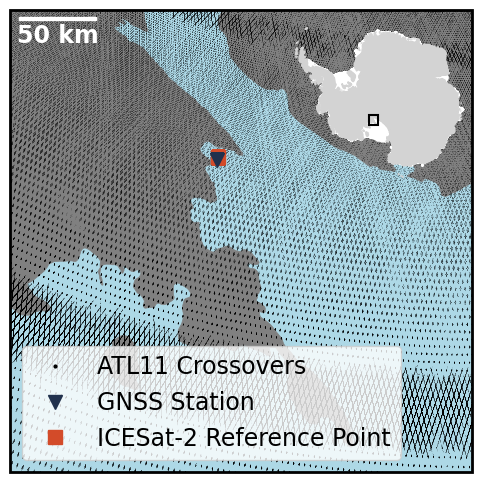

In [19]:
import cartopy.crs as ccrs
import matplotlib.lines as mlines

ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
fig, ax = plt.subplots(subplot_kw={"projection": ps71_projection}, figsize=(6, 6))
for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i] : parts[i + 1]]
        if (
            classification == "Isolated island"
            or classification == "Ice rise or connected island"
            or classification == "Grounded ice or land"
        ):
            ax.fill(*zip(*part), color="gray", linewidth=0.5, zorder=2)
        elif classification == "Ice shelf":
            ax.fill(*zip(*part), color="lightblue", linewidth=0.5, zorder=2)
        else:
            print(f"Unknown classification: {classification}")

is2_ref_pt_x, is2_ref_pt_y = ll2xy(lat_lon[min_index][1], lat_lon[min_index][0])
gz05_x, gz05_y = ll2xy(gz05_lon, gz05_lat)
ax.scatter(
    gz05_x, gz05_y, color="#21314D", s=100, zorder=5, label="GNSS Station", marker="v"
)
ax.scatter(
    is2_ref_pt_x,
    is2_ref_pt_y,
    color="#D34B29",
    s=100,
    zorder=4,
    label="ICESat-2 Reference Point",
    marker="s",
)
ax.scatter(
    atl11_x,
    atl11_y,
    color="black",
    marker=".",
    s=0.1,
    linewidths=0,
    zorder=3,
    label="ATL11 Crossovers",
)
bbox = [-300000, -800000, 0, -500000]
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

atl11_legend = mlines.Line2D(
    [],
    [],
    color="black",
    marker=".",
    linestyle="None",
    markersize=4,
    label="ATL11 Crossovers",
)
gnss_legend = mlines.Line2D(
    [],
    [],
    color="#21314D",
    marker="v",
    linestyle="None",
    markersize=10,
    label="GNSS Station",
)
is2_legend = mlines.Line2D(
    [],
    [],
    color="#D34B29",
    marker="s",
    linestyle="None",
    markersize=10,
    label="ICESat-2 Reference Point",
)
ax.legend(
    handles=[atl11_legend, gnss_legend, is2_legend], loc="lower left", fontsize=17
)

# Inset Map

bbox_0 = ax.get_position()
inset_x = bbox_0.x1
inset_y = bbox_0.y1
inset = fig.add_axes(
    [
        inset_x - bbox_0.height / 2.5,
        inset_y - bbox_0.height / 2.5,
        bbox_0.height / 2.5,
        bbox_0.height / 2.5,
    ],
    projection=ps71_projection,
)  # [left, bottom, width, height]
inset.patch.set_facecolor("none")
for spine in inset.spines.values():
    spine.set_visible(False)
inset.set_xticks([])
inset.set_yticks([])

plot_shapefile(
    records, shapes, inset, ["lightgray", "white"], ps71_projection, fill=True
)
rect = plt.Rectangle(
    (
        bbox[0],
        bbox[1],
    ),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    zorder=3,
    linewidth=1.5,
    edgecolor="black",
    facecolor="none",
)
inset.add_patch(rect)

scalebar = AnchoredSizeBar(
    ax.transData,
    50000,
    "50 km",
    "upper left",
    pad=0.2,
    sep=3,
    color="white",
    frameon=False,
    size_vertical=2000,
    fontproperties=mpl.font_manager.FontProperties(size=17, weight="bold"),
    label_top=False,
)
ax.add_artist(scalebar)
fig.savefig("REF_PT_location.png", dpi=1000)

In [17]:
# MyHA on both Ross Ice Shelf Stations
fits = []
for sta in [dr16, rs18]:
    t = pd.to_datetime(sta["date"]) - pd.to_datetime(sta["date"].iloc[0])
    t = t.dt.total_seconds() / SEC_IN_HR
    data = sta["z"].values - sta["z"].mean()  # Demean the data
    periods = [constituents[c] for c in constituents]

    initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    print(f"Fitting {sta['sta'].iloc[0]}")
    fit = least_squares(residuals, initial_guess, args=(t, data, periods))
    fits.append(fit)

NameError: name 'dr16' is not defined

In [ ]:
for fit in fits:
    print(fit.x)

dr16_myha = fits[0].x
rs18_myha = fits[1].x

[-0.02204946 -0.03296388  0.03235336 -0.00829674  0.292047   -0.22965672
 -0.11855417  0.04561072  0.11261468  0.34053484 -1.13899472  5.242843
  4.54537195  4.80513682 -0.15394751 -1.47118519]
[ 0.03468259  0.04802398  0.04698975  0.01096687 -0.29248726 -0.22796522
 -0.11628486  0.04426836 -0.64694147  2.68123895  0.00770615  0.3879784
  0.63516217 -4.66444665 -0.11512917  0.43619787]


: 

In [ ]:
# Compare to CATS
import pyTMD

tide_dir = "/mnt/c/users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

lats = [-81.593, -80.1328]
lons = [177.335, 179.3671]
amps = []

for lat, lon in zip(lats, lons):
    model = pyTMD.io.model(tide_dir, format="netcdf").elevation(tide_mod)
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
    )
    c = constituents.fields
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lons),
        np.atleast_1d(lats),
        constituents,
        type=model.type,
        method="spline",
        extrapolate=True,
    )
    amps.append(amp)
    for i in range(len(c)):
        print(f"Constitutent: {c[i]}, Amplitude: {amp[0][i]}, Phase: {ph[0][i]}")

Constitutent: m2, Amplitude: 0.04154001548886299, Phase: 196.9391373402421
Constitutent: s2, Amplitude: 0.039797671139240265, Phase: 134.29444180036035
Constitutent: n2, Amplitude: 0.04383499175310135, Phase: 104.79398734105068
Constitutent: k2, Amplitude: 0.015746118500828743, Phase: 144.99263539924303
Constitutent: k1, Amplitude: 0.3531414568424225, Phase: 195.63925671854028
Constitutent: o1, Amplitude: 0.2961300313472748, Phase: 179.27314993786192
Constitutent: p1, Amplitude: 0.12311189621686935, Phase: 191.63947061982412
Constitutent: q1, Amplitude: 0.06441642343997955, Phase: 170.01045719684083
Constitutent: mf, Amplitude: 0.030790148302912712, Phase: 196.69924743621291
Constitutent: mm, Amplitude: 0.016785873100161552, Phase: 189.06285005732852


In [ ]:
dr16_cats = amps[0][0][:-2]
rs18_cats = amps[1][0][:-2]

print(dr16_cats, rs18_cats)
print(dr16_myha, rs18_myha)

[0.04154001548886299 0.039797671139240265 0.04383499175310135
 0.015746118500828743 0.3531414568424225 0.2961300313472748
 0.12311189621686935 0.06441642343997955] [0.04154001548886299 0.039797671139240265 0.04383499175310135
 0.015746118500828743 0.3531414568424225 0.2961300313472748
 0.12311189621686935 0.06441642343997955]
[-0.02204946 -0.03296388  0.03235336 -0.00829674  0.292047   -0.22965672
 -0.11855417  0.04561072  0.11261468  0.34053484 -1.13899472  5.242843
  4.54537195  4.80513682 -0.15394751 -1.47118519] [ 0.03468259  0.04802398  0.04698975  0.01096687 -0.29248726 -0.22796522
 -0.11628486  0.04426836 -0.64694147  2.68123895  0.00770615  0.3879784
  0.63516217 -4.66444665 -0.11512917  0.43619787]


True: 0.125, Fitted: 0.12207
True: 0.138, Fitted: 0.15431
True: 0.112, Fitted: 0.17553
True: 0.048, Fitted: 0.06559
True: 0.452, Fitted: 0.54852
True: 0.371, Fitted: 0.40672
True: 0.144, Fitted: 0.11323
True: 0.076, Fitted: 0.04432
True: 221.062, Fitted: 0.19996
True: 164.575, Fitted: 0.72920
True: 132.822, Fitted: 1.44135
True: 174.373, Fitted: 1.33101
True: 198.697, Fitted: 0.51812
True: 182.270, Fitted: 0.66548
True: 195.884, Fitted: 4.90802
True: 172.692, Fitted: 0.93391


Text(0, 0.5, 'Tide [m]')

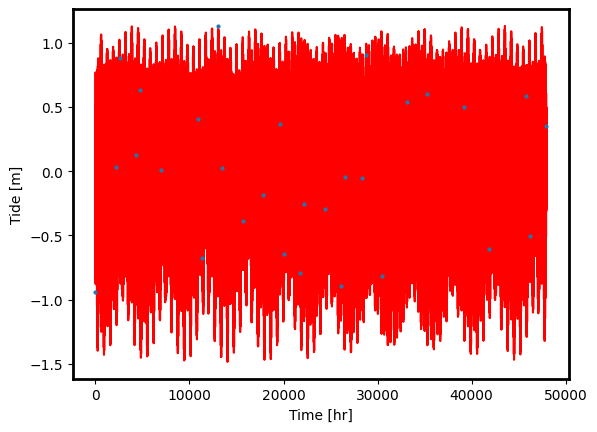

In [13]:
import scipy

t = df["time"].values
data = df["h_corr"].values - df["dac"].values


data = scipy.signal.detrend(data, type="linear")  # Detrend the data
periods = [constituents[c] for c in constituents]

# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, data, periods))

IS2_MYHA = []
# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")
    IS2_MYHA.append(fitted)

fig, ax = plt.subplots()
ax.scatter(t, data, s=4)
fit_times = np.arange(0, df["time"].iloc[-1], 0.1)
fit_tide = tide_model(fit_times, periods, fit.x)
ax.plot(fit_times, fit_tide, color="red", zorder=0)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Tide [m]")

In [14]:
# Utide analysis
t = df["time"].values
data = df["h_corr"].values
soln_IS2_UTIDE = solve(t, data, lat=-84.2986, method="ols", conf_int="MC")
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: BET1, Amplitude: 16968765737.224478, A_ci: nan Phase: 1.9079940042256327, g_ci: nan
Constitutent: 2MN6, Amplitude: 12042125826.796362, A_ci: nan Phase: 4.2056695652979155, g_ci: nan
Constitutent: SA, Amplitude: 1727934448.9540884, A_ci: 6.174354231028535e-05 Phase: 5.212865105390438, g_ci: 1.3044269245767545e-12
Constitutent: CHI1, Amplitude: 1326690620.791549, A_ci: nan Phase: 5.481760215437391, g_ci: nan
Constitutent: MN4, Amplitude: 1307851530.6017864, A_ci: nan Phase: 6.207330637545842, g_ci: nan
Constitutent: MKS2, Amplitude: 1024394007.9980122, A_ci: nan Phase: 5.945521671391247, g_ci: nan
Constitutent: SSA, Amplitude: 939338941.2290267, A_ci: nan Phase: 2.761252491053772, g_ci: nan
Constitutent: M4, Amplitude: 832809793.7629216, A_ci: nan Phase: 0.5574669735394724, g_ci: nan
Constitutent: M3, Amplitude: 724161494.486795, A_ci: nan Phase: 4.567023863462815, g_ci: nan
Constitutent: MO3, Amplitude: 715451649.1507511, A_ci: nan

In [15]:
# Try with taking points from CATS
tide_dir = "/mnt/c/users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

tide_times = df["datetime"].values
tide_times = [datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in tide_times]
gz05_lat = -84.2986
gz05_lon = -164.5206

tides = Tides.Tide(tide_mod, tide_dir)
tide_results = tides.tidal_elevation(
    [gz05_lon],
    [gz05_lat],
    tide_times,
).data.T[0]

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


True: 0.125, Fitted: 0.14647
True: 0.138, Fitted: 0.13740
True: 0.112, Fitted: 0.13245
True: 0.048, Fitted: 0.06820
True: 0.452, Fitted: 0.48581
True: 0.371, Fitted: 0.40833
True: 0.144, Fitted: 0.15669
True: 0.076, Fitted: 0.07563
True: 221.062, Fitted: 2.64708
True: 164.575, Fitted: 0.57216
True: 132.822, Fitted: 1.41380
True: 174.373, Fitted: 1.38180
True: 198.697, Fitted: 0.55543
True: 182.270, Fitted: 0.55896
True: 195.884, Fitted: 11.10895
True: 172.692, Fitted: 0.31578


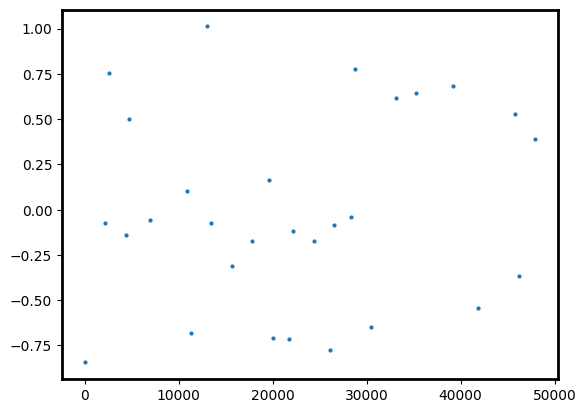

In [16]:
periods = [constituents[c] for c in constituents]
t = df["time"].values
data = tide_results / 100
# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, data, periods))

CATS_AT_IS2 = []
# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")
    CATS_AT_IS2.append(fitted)

fig, ax = plt.subplots()
ax.scatter(t, data, s=4)

In [54]:
# Try complex fit for stability?
t = df["time"].values
periods = [constituents[c] for c in constituents]
y = tide_results / 100

# Design matrix
X = np.vstack([np.exp(1j * 2 * np.pi * t / period) for period in periods]).T
c_fit, *_ = np.linalg.lstsq(X, 1j * y, rcond=None)

amp = np.abs(c_fit)
phase = np.angle(c_fit) % (2 * np.pi) * 180 / np.pi
amp_cats_at_is2 = amp
phase_cats_at_is2 = phase

for f, ap, ph in zip(periods, amp, phase):
    print(f"Period {f:.2f} Hr: Amplitude = {ap:.3f}, Phase = {ph:.3f} deg")

Period 12.42 Hr: Amplitude = 0.066, Phase = 316.494 deg
Period 12.00 Hr: Amplitude = 0.114, Phase = 65.776 deg
Period 12.66 Hr: Amplitude = 0.098, Phase = 11.334 deg
Period 11.97 Hr: Amplitude = 0.044, Phase = 142.282 deg
Period 23.93 Hr: Amplitude = 0.296, Phase = 302.140 deg
Period 25.82 Hr: Amplitude = 0.238, Phase = 250.311 deg
Period 24.07 Hr: Amplitude = 0.088, Phase = 286.009 deg
Period 26.87 Hr: Amplitude = 0.054, Phase = 221.409 deg


/tmp/ipykernel_2450/4108058264.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(constituents.keys()))
/tmp/ipykernel_2450/4108058264.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(constituents.keys()))


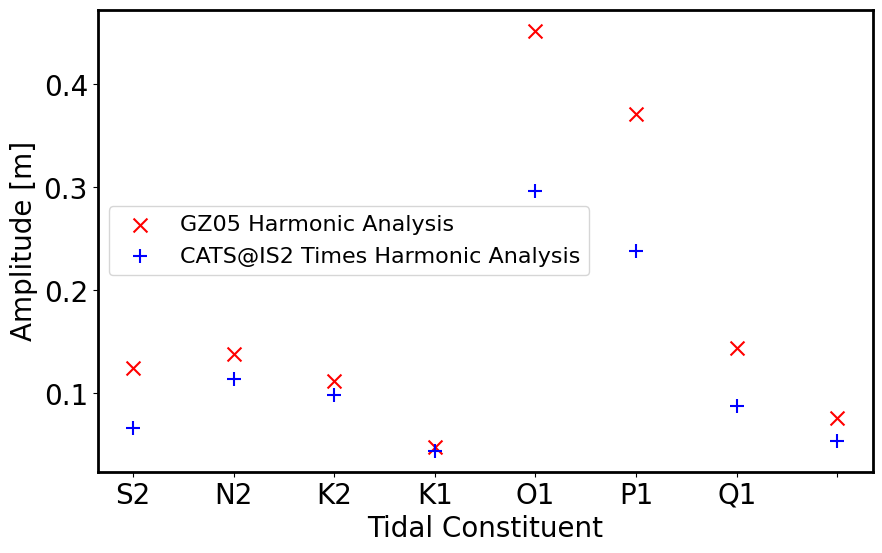

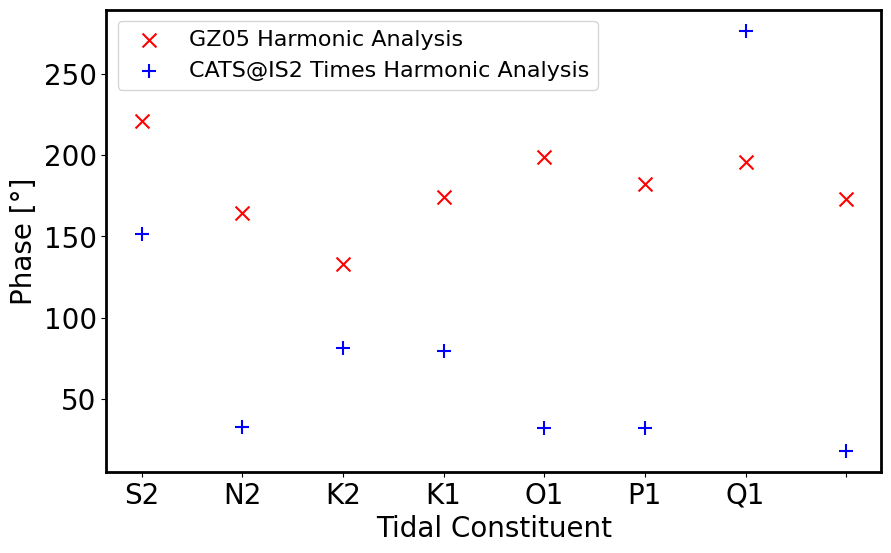

In [ ]:
# Violin plot of fits with true and expected based on CATS values
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    range(8),
    true_values[:8],
    color="red",
    label="GZ05 Harmonic Analysis",
    marker="x",
    s=100,
)
ax.scatter(
    range(8),
    amp,
    color="blue",
    label="CATS@IS2 Times Harmonic Analysis",
    marker="+",
    s=100,
)
ax.set_xticklabels(list(constituents.keys()))
ax.legend(fontsize=16)
ax.set_ylabel("Amplitude [m]", fontsize=20)
ax.set_xlabel("Tidal Constituent", fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xticklabels(list(constituents.keys()))
ax.scatter(
    range(8),
    true_values[8:],
    color="red",
    label="GZ05 Harmonic Analysis",
    marker="x",
    s=100,
)
"""
ax.scatter(
    range(8),
    cats_phases,
    color="blue",
    label="CATS@IS2 Times Harmonic Analysis",
    marker="+",
    s=100,
)
"""
ax.legend(fontsize=16)
ax.set_ylabel("Phase [°]", fontsize=20)
ax.set_xlabel("Tidal Constituent", fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

In [69]:
# Try complex fit
t = df["time"].values
periods = [constituents[c] for c in constituents]
y = tide_results / 100

# Design matrix
X = np.vstack([np.exp(1j * 2 * np.pi * t / period) for period in periods]).T

amps = []
phases = []
err = 0.1
for i in range(1000):
    # Add random noise to data
    y_noisy = y + np.random.normal(0, err, len(y))

    c_fit, *_ = np.linalg.lstsq(X, 1j * y_noisy, rcond=None)

    amp = np.abs(c_fit)
    phase = np.angle(c_fit) % (2 * np.pi) * 180 / np.pi
    amps.append(amp)
    phases.append(phase)

amps = list(map(list, zip(*amps)))
phases = list(map(list, zip(*phases)))

/tmp/ipykernel_2450/1211422392.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(constituents.keys()))
/tmp/ipykernel_2450/1211422392.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(constituents.keys()))


Text(0.5, 1.0, '0.1 Meter Error Synthetic Monte-Carlo Test')

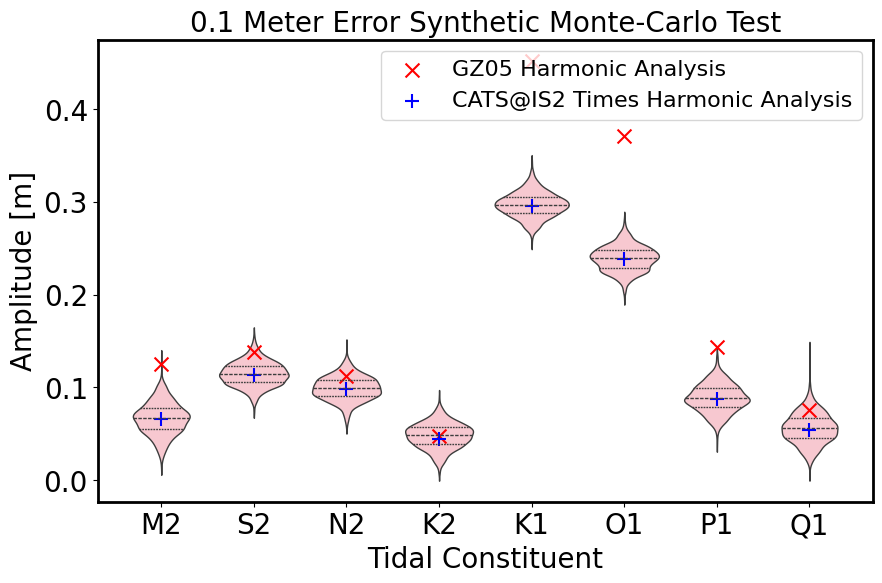

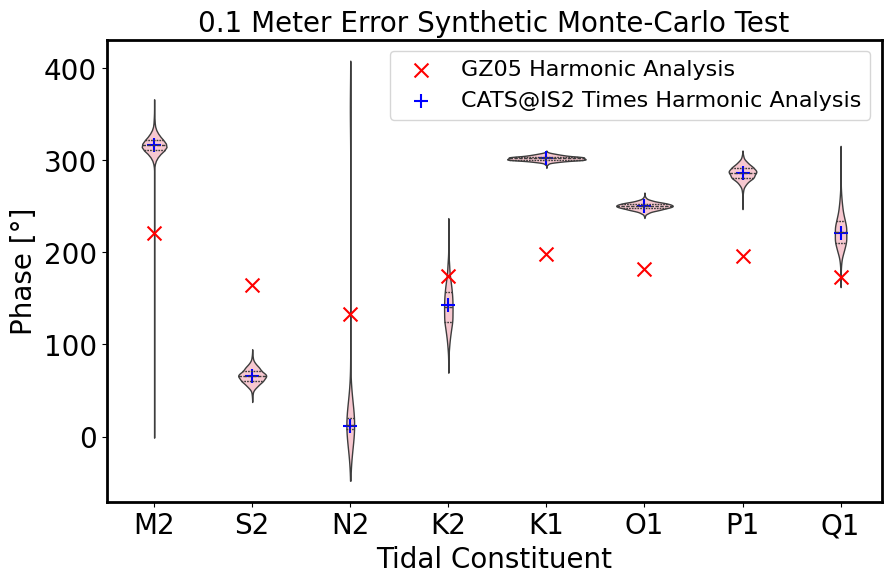

In [67]:
# Violin plot of fits with true and expected based on CATS values
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=amps, ax=ax, inner="quartile", linewidth=1, color="pink")
# ax.set_xticks(range(7))  # positions: one per violin
ax.set_xticklabels(list(constituents.keys()))
ax.scatter(
    range(8),
    true_values[:8],
    color="red",
    label="GZ05 Harmonic Analysis",
    marker="x",
    s=100,
)
ax.scatter(
    range(8),
    amp_cats_at_is2[:8],
    color="blue",
    label="CATS@IS2 Times Harmonic Analysis",
    marker="+",
    s=100,
)
ax.legend(fontsize=16)
ax.set_ylabel("Amplitude [m]", fontsize=20)
ax.set_xlabel("Tidal Constituent", fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_title(f"{err} Meter Error Synthetic Monte-Carlo Test", fontsize=20)

# Violin plot of fits with true and expected phase based on CATS values
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=phases, ax=ax, inner="quartile", linewidth=1, color="pink")
# sns.boxplot(data=(cols), ax=ax, width=0.5, color="pink", linewidth=1)
# ax.set_xticks(range(7))  # positions: one per violin
ax.set_xticklabels(list(constituents.keys()))
ax.scatter(
    range(8),
    true_values[8:],
    color="red",
    label="GZ05 Harmonic Analysis",
    marker="x",
    s=100,
)
cats_phases = np.mod(np.array(CATS_AT_IS2[8:]), 2 * np.pi) * 180 / np.pi
ax.scatter(
    range(8),
    phase_cats_at_is2,
    color="blue",
    label="CATS@IS2 Times Harmonic Analysis",
    marker="+",
    s=100,
)
ax.legend(fontsize=16)
ax.set_ylabel("Phase [°]", fontsize=20)
ax.set_xlabel("Tidal Constituent", fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_title(f"{err} Meter Error Synthetic Monte-Carlo Test", fontsize=20)

In [ ]:
# Monte Carlo analysis of random errors and or biases in ICESat-2 data (Measurement error, propagation of satstrugi, etc.)

periods = [constituents[c] for c in constituents]
t = df["time"].values
data = tide_results / 100
initial_guess = [
    0.25,
    0.25,
    0.25,
    0.25,
    0.25,
    0.25,
    0.25,
    0.25,
    np.pi,
    np.pi,
    np.pi,
    np.pi,
    np.pi,
    np.pi,
    np.pi,
    np.pi,
]

fits = []
err = 0.05
for i in range(1000):
    # Add random noise to data
    noisy_data = data + np.random.normal(0, err, len(data))

    fit = least_squares(residuals, initial_guess, args=(t, noisy_data, periods))
    # If fit.x[n] < 0 with n<8, add pi to the correspondsing fit.x[n+8]
    for n in range(8):
        if fit.x[n] < 0:
            fit.x[n + 8] += np.pi
    fits.append(np.abs(fit.x))

columns = list(map(list, zip(*fits)))

amp

/tmp/ipykernel_2450/3301723490.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(constituents.keys()))
/tmp/ipykernel_2450/3301723490.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(constituents.keys()))


Text(0.5, 1.0, '0.05 Meter Error Synthetic Monte-Carlo Test')

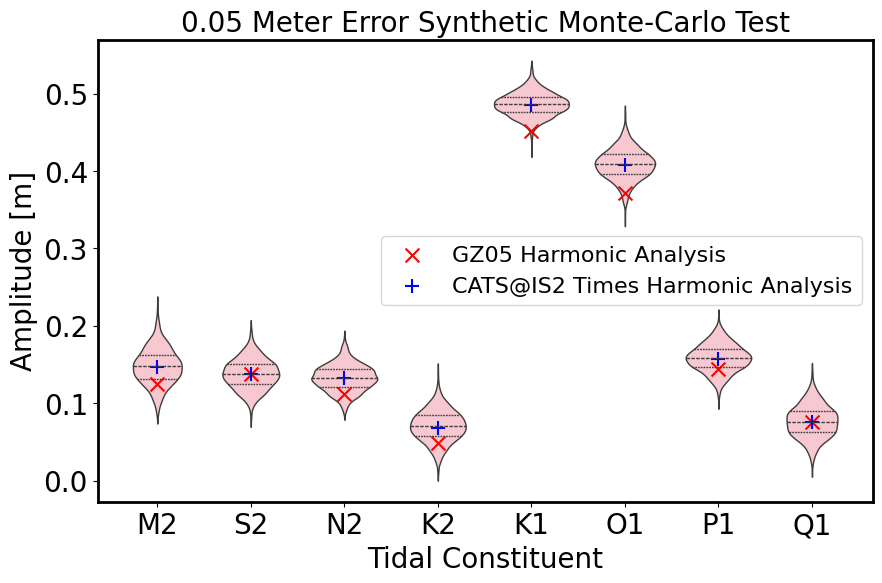

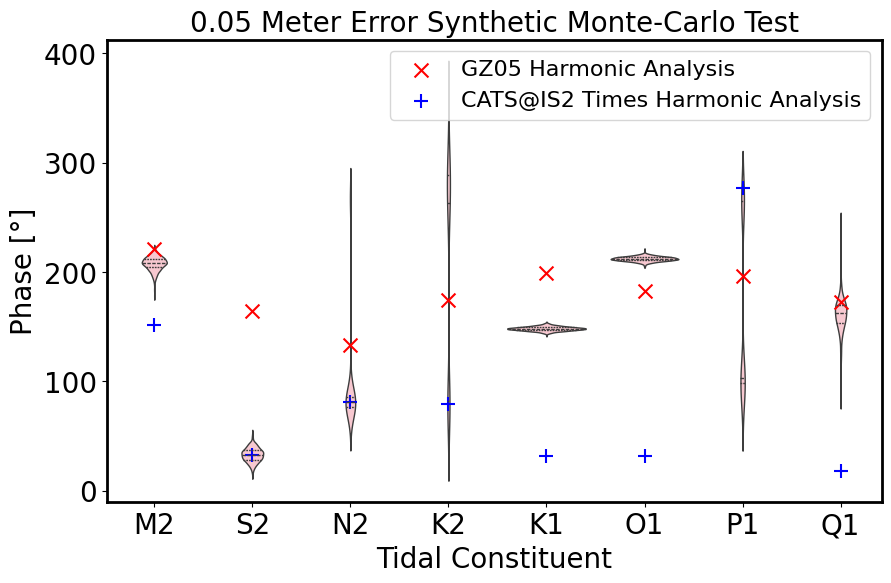

In [30]:
# Violin plot of fits with true and expected based on CATS values
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=columns[:8], ax=ax, inner="quartile", linewidth=1, color="pink")
# ax.set_xticks(range(7))  # positions: one per violin
ax.set_xticklabels(list(constituents.keys()))
ax.scatter(
    range(8),
    true_values[:8],
    color="red",
    label="GZ05 Harmonic Analysis",
    marker="x",
    s=100,
)
ax.scatter(
    range(8),
    CATS_AT_IS2[:8],
    color="blue",
    label="CATS@IS2 Times Harmonic Analysis",
    marker="+",
    s=100,
)
ax.legend(fontsize=16)
ax.set_ylabel("Amplitude [m]", fontsize=20)
ax.set_xlabel("Tidal Constituent", fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_title(f"{err} Meter Error Synthetic Monte-Carlo Test", fontsize=20)

# Violin plot of fits with true and expected phase based on CATS values
cols = [np.mod(np.array(column), 2 * np.pi) * 180 / np.pi for column in columns[8:]]
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=(cols), ax=ax, inner="quartile", linewidth=1, color="pink")
# sns.boxplot(data=(cols), ax=ax, width=0.5, color="pink", linewidth=1)
# ax.set_xticks(range(7))  # positions: one per violin
ax.set_xticklabels(list(constituents.keys()))
ax.scatter(
    range(8),
    true_values[8:],
    color="red",
    label="GZ05 Harmonic Analysis",
    marker="x",
    s=100,
)
cats_phases = np.mod(np.array(CATS_AT_IS2[8:]), 2 * np.pi) * 180 / np.pi
ax.scatter(
    range(8),
    cats_phases,
    color="blue",
    label="CATS@IS2 Times Harmonic Analysis",
    marker="+",
    s=100,
)
ax.legend(fontsize=16)
ax.set_ylabel("Phase [°]", fontsize=20)
ax.set_xlabel("Tidal Constituent", fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_title(f"{err} Meter Error Synthetic Monte-Carlo Test", fontsize=20)

In [18]:
import scipy
import matplotlib.dates as mdates

detrended = df["h_corr"].values - df["dac"].values
detrended = scipy.signal.detrend(detrended, type="linear")

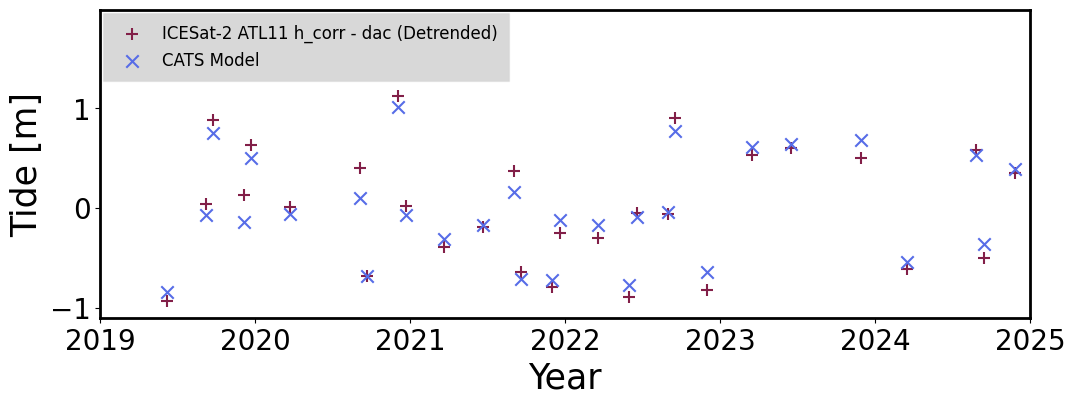

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(
    tide_times,
    detrended,
    s=80,
    label="ICESat-2 ATL11 h_corr - dac (Detrended)",
    marker="+",
    color="#821f48",
)
ax.scatter(
    tide_times,
    tide_results / 100,
    s=80,
    color="#576ce7",
    label="CATS Model",
    marker="x",
)
ax.set_xlabel("Year", fontsize=25)
ax.set_ylabel("Tide [m]", fontsize=25)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2025, 1, 1))
ax.set_ylim(-1.1, 1.99)
# Set x axis in years
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

legend = ax.legend(loc="upper left", fontsize=12, facecolor="gray", framealpha=0.3)
legend.get_frame().set_boxstyle("Square")
fig.savefig("ISE_CATS_COMP.png", dpi=1000, bbox_inches="tight")

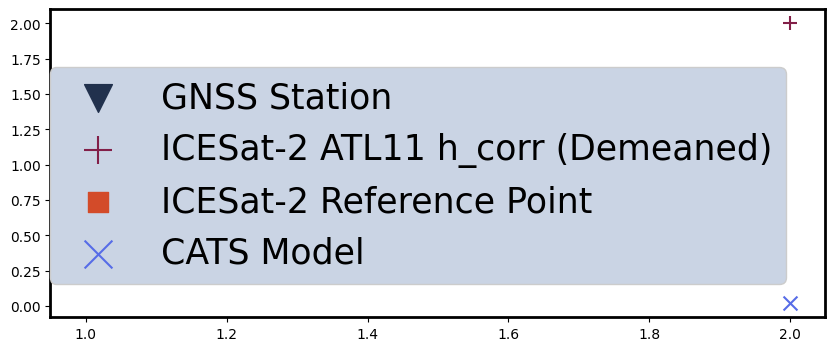

In [37]:
# Make large legend symbols
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(1, 1, color="#21314D", s=100, zorder=5, label="GNSS Station", marker="v")
ax.scatter(
    2, 2, s=100, label="ICESat-2 ATL11 h_corr (Demeaned)", marker="+", color="#821f48"
)
ax.scatter(
    1, 1, color="#D34B29", s=50, zorder=3, label="ICESat-2 Reference Point", marker="s"
)
ax.scatter(2, 2 / 100, s=100, color="#576ce7", label="CATS Model", marker="x")
fig.legend(
    loc="center",
    fontsize=25,
    facecolor="#CAD4E4",
    framealpha=1,
    markerscale=2,
)
fig.savefig("legend.png", dpi=500, bbox_inches="tight")

In [ ]:
# See if we can get the correct answer by sampling more often.

# Hourly sampling between the first and last time
tide_times = pd.date_range(
    start=df["datetime"].iloc[0], end=df["datetime"].iloc[-1], freq="h"
)

gz05_lat = -84.2986
gz05_lon = -164.5206

tides = Tides.Tide(tide_mod, tide_dir)
tide_results = tides.tidal_elevation(
    [gz05_lon],
    [gz05_lat],
    tide_times,
).data.T[0]

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


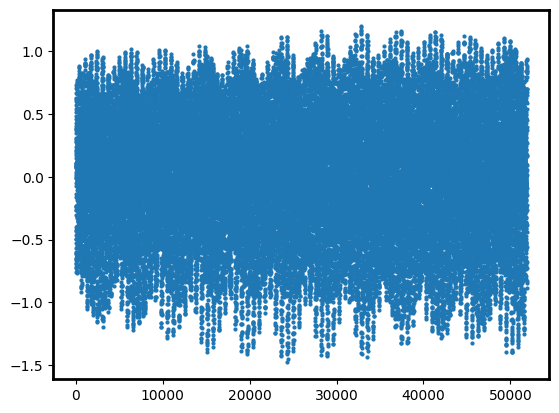

In [ ]:
# Convert tide_times to hours since first time
plot_times = (tide_times - tide_times[0]).total_seconds() / SEC_IN_HR

# Plot
fig, ax = plt.subplots()
ax.scatter(plot_times, tide_results / 100, s=4)

In [ ]:
# Utide analysis
soln_CATS_UTIDE = solve(
    tide_times, tide_results / 100, lat=-84.2986, method="ols", conf_int="MC"
)
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: BET1, Amplitude: 95177660586.01624, A_ci: nan Phase: 1.9361148810343378, g_ci: nan
Constitutent: 2MN6, Amplitude: 54150634022.53228, A_ci: nan Phase: 4.256319371110995, g_ci: nan
Constitutent: SA, Amplitude: 10470594043.77994, A_ci: 3.837730885640808e-05 Phase: 5.269385765322034, g_ci: 1.464748754308995e-13
Constitutent: SSA, Amplitude: 6207239054.3987465, A_ci: nan Phase: 2.961117163799526, g_ci: nan
Constitutent: NO1, Amplitude: 3477977375.8309712, A_ci: nan Phase: 2.5200286480066008, g_ci: nan
Constitutent: CHI1, Amplitude: 3208781371.0927505, A_ci: nan Phase: 6.005727261021783, g_ci: nan
Constitutent: M3, Amplitude: 2013363791.6446362, A_ci: nan Phase: 5.49215059569125, g_ci: nan
Constitutent: M2, Amplitude: 1937218863.8665376, A_ci: nan Phase: 3.2706939246534374, g_ci: nan
Constitutent: MKS2, Amplitude: 1880605560.418732, A_ci: nan Phase: 0.5260237439920208, g_ci: nan
Constitutent: H1, Amplitude: 1825986343.078276, A_ci: nan 

In [ ]:
tide_times

DatetimeIndex(['2019-03-26 05:23:43.817000', '2019-03-26 06:23:43.817000',
               '2019-03-26 07:23:43.817000', '2019-03-26 08:23:43.817000',
               '2019-03-26 09:23:43.817000', '2019-03-26 10:23:43.817000',
               '2019-03-26 11:23:43.817000', '2019-03-26 12:23:43.817000',
               '2019-03-26 13:23:43.817000', '2019-03-26 14:23:43.817000',
               ...
               '2025-02-24 03:23:43.817000', '2025-02-24 04:23:43.817000',
               '2025-02-24 05:23:43.817000', '2025-02-24 06:23:43.817000',
               '2025-02-24 07:23:43.817000', '2025-02-24 08:23:43.817000',
               '2025-02-24 09:23:43.817000', '2025-02-24 10:23:43.817000',
               '2025-02-24 11:23:43.817000', '2025-02-24 12:23:43.817000'],
              dtype='datetime64[ns]', length=51896, freq='h')

In [ ]:
periods = [constituents[c] for c in constituents]
data = tide_results / 100
# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(plot_times, data, periods))


# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")

True: 0.125, Fitted: 0.12309
True: 0.138, Fitted: 0.14453
True: 0.112, Fitted: 0.13642
True: 0.048, Fitted: 0.07198
True: 0.452, Fitted: 0.47432
True: 0.371, Fitted: 0.39462
True: 0.144, Fitted: 0.15748
True: 0.076, Fitted: 0.08549
True: 221.062, Fitted: 0.08853
True: 164.575, Fitted: 0.02060
True: 132.822, Fitted: 0.17774
True: 174.373, Fitted: 0.32605
True: 198.697, Fitted: 0.53664
True: 182.270, Fitted: 0.79038
True: 195.884, Fitted: 0.49466
True: 172.692, Fitted: 0.77409


In [ ]:
# load gz05 data and perform 2 harmonic analyses in UTIDE on SERAC:

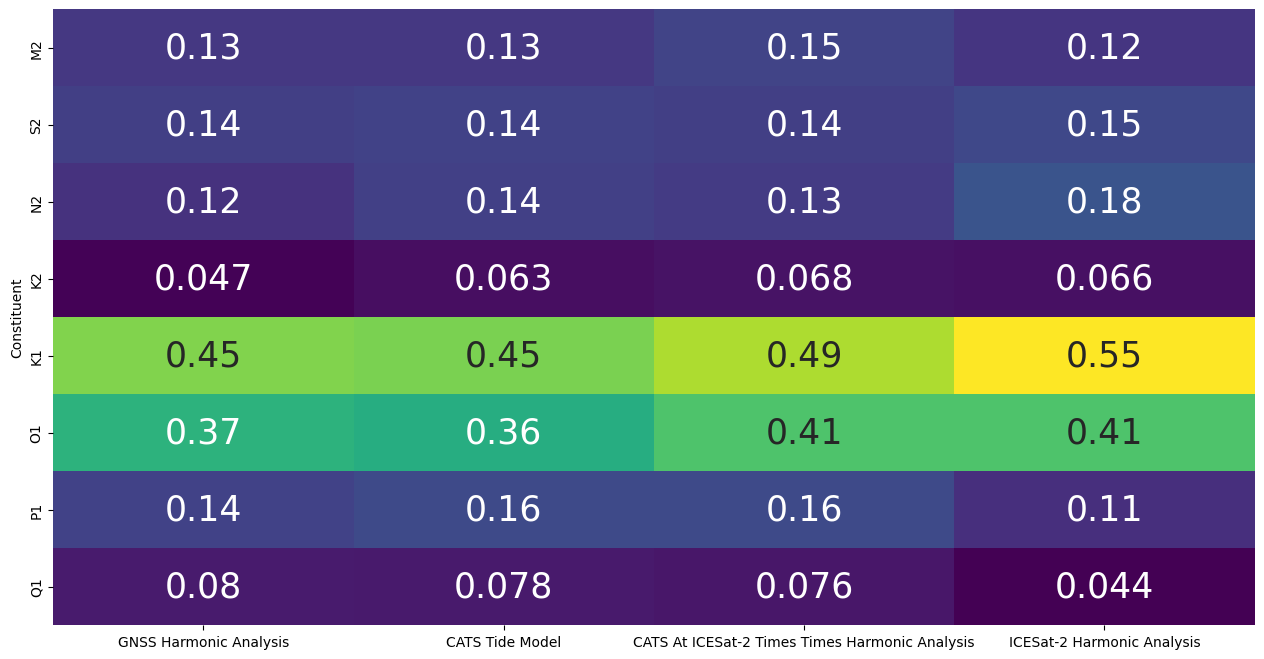

In [ ]:
# Summary Plot FOR POSTER

# Table of constitutents colored by True - Estimated from my simple HA and python's UTide

df_plotting = pd.DataFrame(
    {
        "Constituent": list(constituents.keys()),
        "GNSS Harmonic Analysis": [
            0.12663,
            0.13840,
            0.11655,
            0.04692,
            0.45270,
            0.36785,
            0.14390,
            0.08005,
        ],  # From UTide on SERAC
        "CATS Tide Model": [
            0.12530586123466492,
            0.14462734758853912,
            0.13967309892177582,
            0.06251237541437149,
            0.44746169447898865,
            0.35937005281448364,
            0.15769679844379425,
            0.07832222431898117,
        ],
        "CATS At ICESat-2 Times Times Harmonic Analysis": CATS_AT_IS2[:8],
        "ICESat-2 Harmonic Analysis": IS2_MYHA[:8],
    }
)

# Make plot
df_for_plot = df_plotting.set_index(df_plotting.columns[0])
plt.figure(figsize=(15.5, 8))
plot = sns.heatmap(
    df_for_plot, annot=True, cmap="viridis", cbar=False, annot_kws={"size": 25}
)
plt.savefig("Constituent_Comparison.png", dpi=500, bbox_inches="tight")

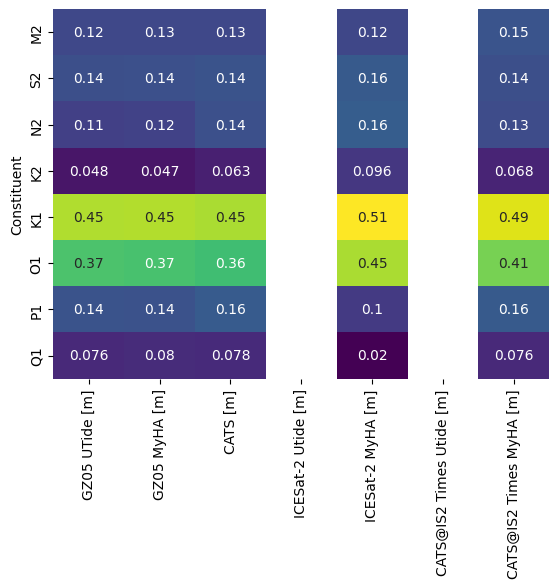

In [36]:
# Summary Plot

# Table of constitutents colored by True - Estimated from my simple HA and python's UTide

df_plotting = pd.DataFrame(
    {
        "Constituent": list(constituents.keys()),
        "GZ05 UTide [m]": true_values[:8],
        "GZ05 MyHA [m]": [
            0.12663,
            0.13840,
            0.11655,
            0.04692,
            0.45270,
            0.36785,
            0.14390,
            0.08005,
        ],  # From UTide on SERAC
        "CATS [m]": [
            0.12530586123466492,
            0.14462734758853912,
            0.13967309892177582,
            0.06251237541437149,
            0.44746169447898865,
            0.35937005281448364,
            0.15769679844379425,
            0.07832222431898117,
        ],
        "ICESat-2 Utide [m]": [np.nan] * 8,
        "ICESat-2 MyHA [m]": IS2_MYHA[:8],
        "CATS@IS2 Times Utide [m]": [np.nan] * 8,
        "CATS@IS2 Times MyHA [m]": CATS_AT_IS2[:8],
    }
)

# Make plot
df_for_plot = df_plotting.set_index(df_plotting.columns[0])
plot = sns.heatmap(df_for_plot, annot=True, cmap="viridis", cbar=False)

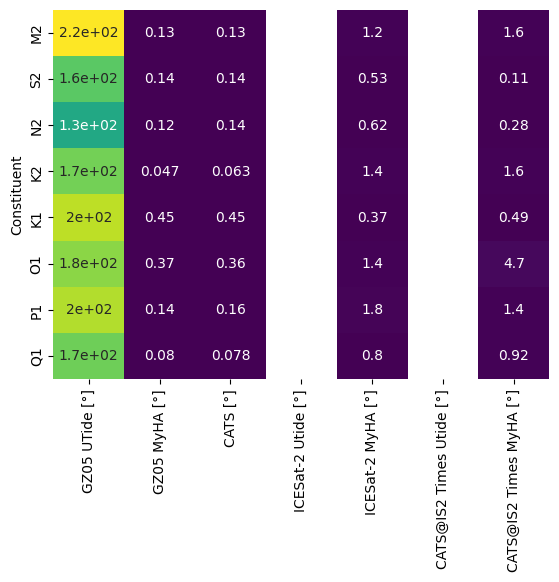

In [ ]:
# Summary Plot Phase

# Table of constitutents colored by True - Estimated from my simple HA and python's UTide

df_plotting = pd.DataFrame(
    {
        "Constituent": list(constituents.keys()),
        "GZ05 UTide [°]": true_values[8:],
        "GZ05 MyHA [°]": [
            0.12663,
            0.13840,
            0.11655,
            0.04692,
            0.45270,
            0.36785,
            0.14390,
            0.08005,
        ],  # From UTide on SERAC
        "CATS [°]": [
            0.12530586123466492,
            0.14462734758853912,
            0.13967309892177582,
            0.06251237541437149,
            0.44746169447898865,
            0.35937005281448364,
            0.15769679844379425,
            0.07832222431898117,
        ],
        "ICESat-2 Utide [°]": [np.nan] * 8,
        "ICESat-2 MyHA [°]": IS2_MYHA[8:],
        "CATS@IS2 Times Utide [°]": [np.nan] * 8,
        "CATS@IS2 Times MyHA [°]": CATS_AT_IS2[8:],
    }
)

# Make plot
df_for_plot = df_plotting.set_index(df_plotting.columns[0])
plot = sns.heatmap(df_for_plot, annot=True, cmap="viridis", cbar=False)